# Single line extraction
Investigate the effect of RV shift of HD30501 during its orbit of a single line at 50000.


In [1]:
from __future__ import division 
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
from spectrum_overload.Spectrum import Spectrum as sp
from scipy import interpolate
from scipy.interpolate import interp1d

sys.path.append('/home/jneal/Phd/Codes/UsefulModules/')
#print(sys.path)
import IP_Convolution as ipc

c = 299792.458   # Speed of light km/s

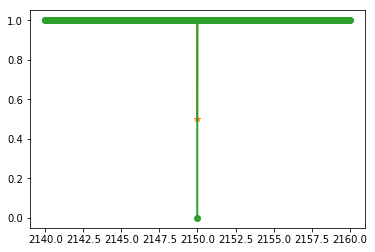

In [2]:
# Create a high res spectrum around 2150 nm

wl = np.linspace(2140, 2160, 1500)
flux = np.ones_like(wl)
#Turn one value to 0 and one to 0.5 arond 2150 nm

flux_0 = copy.copy(flux)
flux_0p5 = copy.copy(flux)
indx_2150nm = np.argmin(abs(wl-2150))
flux_0[indx_2150nm] = 0
flux_0p5[indx_2150nm] = 0.5
plt.plot(wl,flux,'.-')
plt.plot(wl,flux_0p5,'*-')
plt.plot(wl,flux_0,'o-')
plt.show()


[2140.0, 2160.0]
Starting the Resolution convolution...
Single-Process convolution has been completed in 0:00:00.058915.



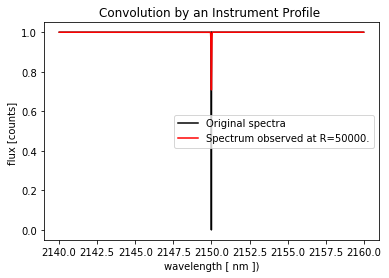

Starting the Resolution convolution...
Single-Process convolution has been completed in 0:00:00.059794.



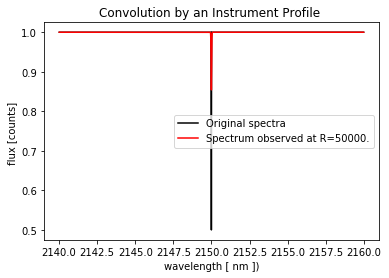

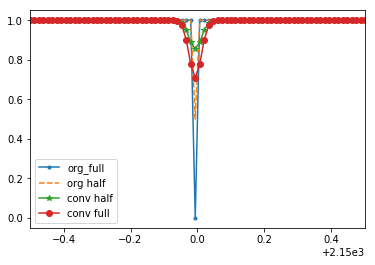

In [3]:
# Convolve to R=50000
#wav_0, flux_0 = ipc.IPconvolution(wl, flux_0, chip_lim, R=100000)
#wav_0p5,flux_0p5 = ipc.IPconvolution(wl, flux_0p5, chip_lim, R=1000000)

R = 50000
chip_lim = [wl[0], wl[-1]]
print(chip_lim)
wav_0, conv_flux_0 = ipc.IPconvolution(wl, flux_0, chip_lim, R=R, verbose=False)
wav_0p5, conv_flux_0p5 = ipc.IPconvolution(wl, flux_0p5, chip_lim, R=R, verbose=False)


plt.plot(wl,flux_0,'.-', label="org_full")
plt.plot(wl,flux_0p5,'--', label="org half")
plt.plot(wav_0p5,conv_flux_0p5,'*-', label="conv half")
plt.plot(wav_0,conv_flux_0,'o-', label="conv full")
plt.xlim(2149.5, 2150.5)
plt.legend(loc=0)
plt.show()


I now have a spectrum of a single line at 2150nm with R=50000. I will take two copies of this and RV shift one of these by the RV amount. The RV amount accounts for the difference between the two "observations". I will then calculate the RV of HD30501 over its orbital phase and apply different RV values to one of the spectra. I will calculate the difference between the peaks of the lines and the amplitude of the lines as a interesting test. 

<class 'spectrum_overload.Spectrum.Spectrum'>
instance True


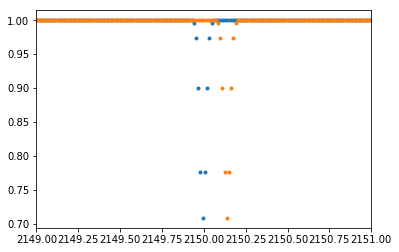

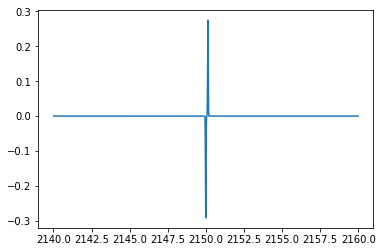

In [4]:
# Test with RV=1000
# Using my new spectrum_overload code
fixed_spec = sp(flux=conv_flux_0,xaxis=wav_0,calibrated=True)
moving_spec = copy.copy(fixed_spec)

#np.interp(wav_0, )
moving_spec.doppler_shift(20)
print(fixed_spec)
print(moving_spec)
print(type(moving_spec))
print("instance", isinstance(moving_spec, sp))

plt.plot(fixed_spec.xaxis, fixed_spec.flux,".", label="fixed")

plt.plot(moving_spec.xaxis, moving_spec.flux,".", label="Moving")
plt.xlim([2149, 2151])
plt.show()
# Manual interpolation aswell
moved_flux = np.interp(fixed_spec.xaxis, moving_spec.xaxis, moving_spec.flux)

# Manual difference for now
diff_spec = fixed_spec.flux - moved_flux

plt.plot(fixed_spec.xaxis, diff_spec)

plt.show()



In [ ]:
# Orbital parameters for HD30501


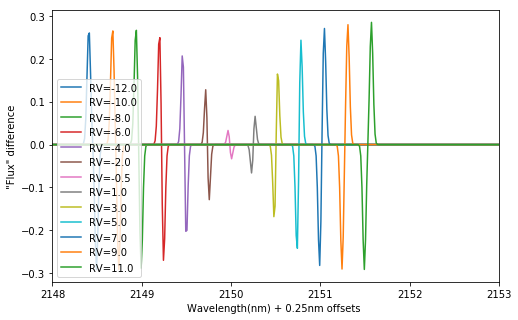

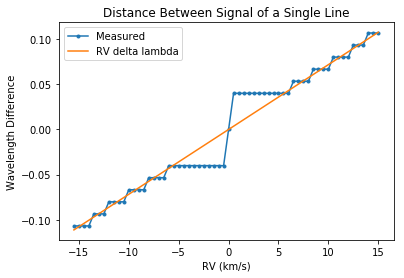

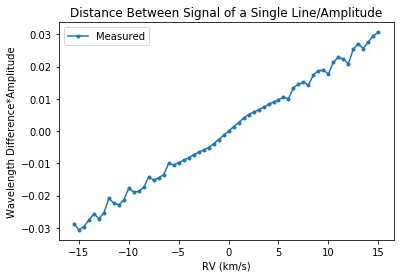

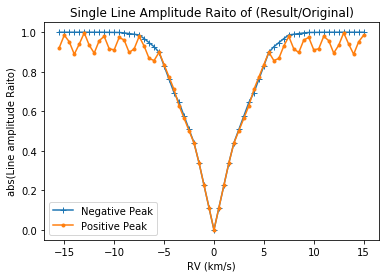

In [5]:
Amp_0 = np.max(1-conv_flux_0)
#Amp_0p5 = np.max(1-conv_flux_0p5)

min_val = []
#min_valp5 = []
max_val =  []
#max_valp5 = []
peak_wav_diff = []
#peak_wav_diffp5 = []
RV_value = []
plt.figure(figsize=(8,5))
counter = 0

for RV in np.arange(-15.5, 15.5,.5):
    #print("This RV value = ", RV)
    # Generate the spectra
    fixed_spec = sp(flux=conv_flux_0,xaxis=wav_0,calibrated=True)
    moving_spec = copy.copy(fixed_spec)
    #fixed_specp5 = sp(flux=conv_flux_0p5,xaxis=wav_0p5,calibrated=True)
    #moving_specp5 = copy.copy(fixed_specp5)
    
    #Doppler shift
    moving_spec.doppler_shift(RV)
    #moving_specp5.doppler_shift(RV)
    
    # Interpolate back # Manual Numpy interpolation aswell
    moved_flux = np.interp(fixed_spec.xaxis, moving_spec.xaxis, moving_spec.flux)
    #moved_fluxp5 = np.interp(fixed_specp5.xaxis, moving_specp5.xaxis, moving_specp5.flux)

    # Difference spectrum
    diff_spec = fixed_spec.flux - moved_flux
    #diff_specp5 = fixed_specp5.flux - moved_fluxp5
    
    # Calculations
    min_loc = np.argmin(diff_spec)
    max_loc = np.argmin(-diff_spec)
    #min_locp5 = np.argmin(diff_specp5)
    #max_locp5 = np.argmax(diff_specp5)

    min_val.append(diff_spec[min_loc])
    #min_valp5.append(diff_specp5[min_locp5])
    max_val.append(diff_spec[max_loc])
    #max_valp5.append(diff_specp5[max_locp5])
    peak_wav_diff.append(fixed_spec.xaxis[max_loc]-fixed_spec.xaxis[min_loc])
    #peak_wav_diffp5.append(fixed_specp5.xaxis[max_locp5]-fixed_specp5.xaxis[min_locp5])
    RV_value.append(RV)
    
    if RV in [-12., -10., -8., -6., -4., -2., -0.5, 1., 3., 5., 7., 9., 11.]:
       
        offset = [-1.5, -1.25, -1, -0.75, -0.5,-0.25, 0, 0.25, 0.5, .75, 1, 1.25, 1.5][counter]
        plt.plot(fixed_spec.xaxis+offset, diff_spec, label="RV={}".format(RV))
        #plt.plot(fixed_spec.xaxis+offset, diff_specp5, label="Half")
        #plt.title("Line minus {}km/s shifted Line".format(RV))
        plt.xlabel("Wavelength(nm) + 0.25nm offsets ")
        plt.ylabel('"Flux" difference')
        plt.xlim([2148,2153])
        #plt.legend(loc=0)
        #plt.show()
        counter += 1
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.legend()        
plt.show()   


#Turn output into np.arrays
min_val = np.asarray(min_val)
#min_valp5 = np.asarray(min_valp5)
max_val =  np.asarray(max_val)
#max_valp5 = np.asarray(max_valp5)
peak_wav_diff = np.asarray(peak_wav_diff)
#peak_wav_diffp5 = np.asarray(peak_wav_diffp5)
RV_value = np.asarray(RV_value)
delta_lambda =  2150 * RV_value/c        # doppler shift value

# Plotting Results
plt.figure()
plt.plot(RV_value, peak_wav_diff, '.-', label="Measured")
#plt.plot(RV_value, peak_wav_diffp5, label="1/2 Peak wavelength diff of extremes")
plt.plot(RV_value, delta_lambda, label="RV delta lambda")
plt.xlabel("RV (km/s)")
plt.ylabel("Wavelength Difference")
plt.title("Distance Between Signal of a Single Line")
plt.legend()
plt.show()

# Plotting Results
plt.figure()
plt.plot(RV_value, peak_wav_diff*abs(max_val),'.-', label="Measured")
#plt.plot(RV_value, peak_wav_diffp5, label="1/2 Peak wavelength diff of extremes")
#plt.plot(RV_value, delta_lambda, label="RV delta lambda")
plt.xlabel("RV (km/s)")
plt.ylabel("Wavelength Difference*Amplitude")
plt.title("Distance Between Signal of a Single Line/Amplitude")
plt.legend()
plt.show()

plt.figure()
plt.plot(RV_value, abs(min_val)/Amp_0, "+-", label="Negative Peak")
#plt.plot(RV_value, abs(min_valp5)/Amp_0p5, "+-", label="1/2 Peak max")
plt.plot(RV_value, abs(max_val)/Amp_0, ".-" , label="Positive Peak")
#plt.plot(RV_value, abs(max_valp5)/Amp_0p5, ".-", label="1/2 Peak max")
plt.xlabel("RV (km/s)")
plt.ylabel("abs(Line amplitude Raito)")
plt.title("Single Line Amplitude Raito of (Result/Original)")
plt.legend(loc=0)
plt.show()


# Same calculation with SCIPY Fitting
Using scipy.interp1D  function
f = interp1d(x, y)
y2 = f(x2)

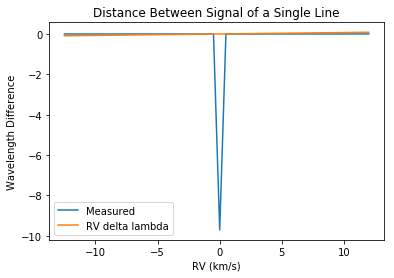

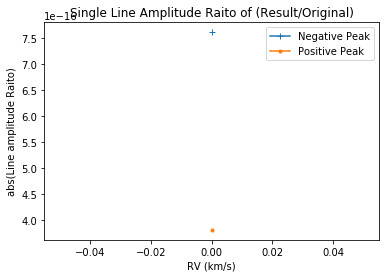

In [6]:
Amp_0 = np.max(1-conv_flux_0)
Amp_0p5 = np.max(1-conv_flux_0p5)

conv_flux_0p5
min_val = []
min_valp5 = []
max_val =  []
max_valp5 = []
peak_wav_diff = []
peak_wav_diffp5 = []
RV_value = []

for RV in np.arange(-12.5,12.5,.5):
    #print("This RV value = ", RV)
    # Generate the spectra
    fixed_spec = sp(flux=conv_flux_0,xaxis=wav_0,calibrated=True)
    moving_spec = copy.copy(fixed_spec)
    #fixed_specp5 = sp(flux=conv_flux_0p5,xaxis=wav_0p5,calibrated=True)
    #moving_specp5 = copy.copy(fixed_specp5)
    
    #Doppler shift
    moving_spec.doppler_shift(RV)
    #moving_specp5.doppler_shift(RV)
    
    # Interpolate back Scipy interp1D function
    f = interp1d(moving_spec.xaxis, moving_spec.flux,kind="cubic", bounds_error=False,fill_value=np.nan)
    #fp5 = interp1d(moving_specp5.xaxis, moving_specp5.flux, bounds_error=False)
    moved_flux = f(fixed_spec.xaxis)
    #moved_fluxp5 = fp5(fixed_specp5.xaxis)
   
    # Difference spectrum
    diff_spec = fixed_spec.flux - moved_flux
    #diff_specp5 = fixed_specp5.flux - moved_fluxp5
    
    # Calculations
    min_loc = np.argmin(diff_spec)
    max_loc = np.argmax(diff_spec)
    #min_locp5 = np.argmin(diff_specp5)
    #max_locp5 = np.argmax(diff_specp5)

    min_val.append(diff_spec[min_loc])
    #min_valp5.append(diff_specp5[min_locp5])
    max_val.append(diff_spec[max_loc])
    #max_valp5.append(diff_specp5[max_locp5])
    peak_wav_diff.append(fixed_spec.xaxis[max_loc]-fixed_spec.xaxis[min_loc])
    #peak_wav_diffp5.append(fixed_specp5.xaxis[max_locp5]-fixed_specp5.xaxis[min_locp5])
    RV_value.append(RV)

#Turn output into np.arrays
min_val = np.asarray(min_val)
#min_valp5 = np.asarray(min_valp5)
max_val =  np.asarray(max_val)
#max_valp5 = np.asarray(max_valp5)
peak_wav_diff = np.asarray(peak_wav_diff)
#peak_wav_diffp5 = np.asarray(peak_wav_diffp5)
RV_value = np.asarray(RV_value)
delta_lambda =  2150 * RV_value/c        # doppler shift value

# Plotting Results
plt.figure()
plt.plot(RV_value, peak_wav_diff, label="Measured")
#plt.plot(RV_value, peak_wav_diffp5, label="1/2 Peak wavelength diff of extremes")
plt.plot(RV_value, delta_lambda, label="RV delta lambda")
plt.xlabel("RV (km/s)")
plt.ylabel("Wavelength Difference")
plt.title("Distance Between Signal of a Single Line")
plt.legend()
plt.show()

plt.figure()
plt.plot(RV_value, abs(min_val)/Amp_0, "+-", label="Negative Peak")
#plt.plot(RV_value, abs(min_valp5)/Amp_0p5, "+-", label="1/2 Peak max")
plt.plot(RV_value, abs(max_val)/Amp_0, ".-" , label="Positive Peak")
#plt.plot(RV_value, abs(max_valp5)/Amp_0p5, ".-", label="1/2 Peak max")
plt.xlabel("RV (km/s)")
plt.ylabel("abs(Line amplitude Raito)")
plt.title("Single Line Amplitude Raito of (Result/Original)")
plt.legend(loc=0)
plt.show()


In [ ]:
# Same calcualtion with SCIPY cubic splice fitting

 Not performing the doppler shift
 Not performing the doppler shift


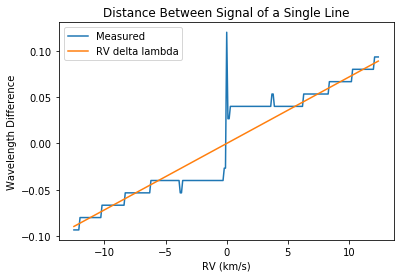

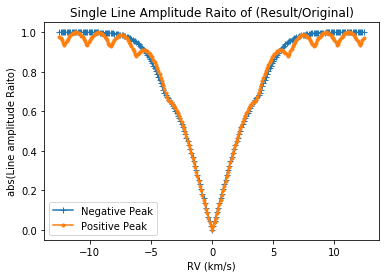

In [7]:
Amp_0 = np.max(1-conv_flux_0)
Amp_0p5 = np.max(1-conv_flux_0p5)

min_val = []
min_valp5 = []
max_val =  []
max_valp5 = []
peak_wav_diff = []
peak_wav_diffp5 = []
RV_value = []

for RV in np.arange(-12.5,12.5,.1):
    #print("This RV value = ", RV)
    # Generate the spectra
    fixed_spec = sp(flux=conv_flux_0,xaxis=wav_0,calibrated=True)
    moving_spec = copy.copy(fixed_spec)
    fixed_specp5 = sp(flux=conv_flux_0p5,xaxis=wav_0p5,calibrated=True)
    moving_specp5 = copy.copy(fixed_specp5)
    
    #Doppler shift
    moving_spec.doppler_shift(RV)
    moving_specp5.doppler_shift(RV)
    
    # Interpolate back # SCIPY cubic spline
    tck = interpolate.splrep(moving_spec.xaxis, moving_spec.flux, s=0)   #s=0 no smothing
    moved_flux = interpolate.splev(fixed_spec.xaxis, tck, der=0)
    tckp5 = interpolate.splrep(moving_specp5.xaxis, moving_specp5.flux, s=0)   #s=0 no smothing
    moved_fluxp5 = interpolate.splev(fixed_specp5.xaxis, tckp5, der=0)


    # Difference spectrum
    diff_spec = fixed_spec.flux - moved_flux
    diff_specp5 = fixed_specp5.flux - moved_fluxp5
    
    # Calculations
    min_loc = np.argmin(diff_spec)
    max_loc = np.argmax(diff_spec)
    min_locp5 = np.argmin(diff_specp5)
    max_locp5 = np.argmax(diff_specp5)

    min_val.append(diff_spec[min_loc])
    min_valp5.append(diff_specp5[min_locp5])
    max_val.append(diff_spec[max_loc])
    max_valp5.append(diff_specp5[max_locp5])
    peak_wav_diff.append(fixed_spec.xaxis[max_loc]-fixed_spec.xaxis[min_loc])
    peak_wav_diffp5.append(fixed_specp5.xaxis[max_locp5]-fixed_specp5.xaxis[min_locp5])
    RV_value.append(RV)

#Turn output into np.arrays
min_val = np.asarray(min_val)
min_valp5 = np.asarray(min_valp5)
max_val =  np.asarray(max_val)
max_valp5 = np.asarray(max_valp5)
peak_wav_diff = np.asarray(peak_wav_diff)
peak_wav_diffp5 = np.asarray(peak_wav_diffp5)
RV_value = np.asarray(RV_value)
delta_lambda =  2150 * RV_value/c    


#Turn output into np.arrays
min_val = np.asarray(min_val)
#min_valp5 = np.asarray(min_valp5)
max_val =  np.asarray(max_val)
#max_valp5 = np.asarray(max_valp5)
peak_wav_diff = np.asarray(peak_wav_diff)
#peak_wav_diffp5 = np.asarray(peak_wav_diffp5)
RV_value = np.asarray(RV_value)
delta_lambda =  2150 * RV_value/c        # doppler shift value

# Plotting Results
plt.figure()
plt.plot(RV_value, peak_wav_diff, label="Measured")
#plt.plot(RV_value, peak_wav_diffp5, label="1/2 Peak wavelength diff of extremes")
plt.plot(RV_value, delta_lambda, label="RV delta lambda")
plt.xlabel("RV (km/s)")
plt.ylabel("Wavelength Difference")
plt.title("Distance Between Signal of a Single Line")
plt.legend()
plt.show()

plt.figure()
plt.plot(RV_value, abs(min_val)/Amp_0, "+-", label="Negative Peak")
#plt.plot(RV_value, abs(min_valp5)/Amp_0p5, "+-", label="1/2 Peak max")
plt.plot(RV_value, abs(max_val)/Amp_0, ".-" , label="Positive Peak")
#plt.plot(RV_value, abs(max_valp5)/Amp_0p5, ".-", label="1/2 Peak max")
plt.xlabel("RV (km/s)")
plt.ylabel("abs(Line amplitude Raito)")
plt.title("Single Line Amplitude Raito of (Result/Original)")
plt.legend(loc=0)
plt.show()


## Trying to apply a fit to find the RV and amplitude?

In [ ]:
import lmfit

# Generate the data


